#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
        * 성능 가이드
            * Accuracy : 0.900~0.968

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 1) 로컬 수행(Ananconda)
            * 제공된 압축파일을 다운받아 압축을 풀고
            * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
        * 2) 구글콜랩
            * 구글 드라이브 바로 밑에 project 폴더를 만들고,
            * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 설치 및 로딩
        * requirements.txt 파일로 부터 라이브러리 설치
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [ ]:
path = 'C:/Users/User/Desktop/'

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# path = '/content/drive/MyDrive/project/'

### (2) 라이브러리 설치 및 불러오기

#### 1) 설치

* requirements.txt 파일을 아래 위치에 두고 다음 코드를 실행하시오.
    * 로컬 : 다음 코드셀 실행
    * 구글콜랩 : requirements.txt 파일을 왼쪽 [파일]탭에 복사해 넣고 다음 코드셀 실행

In [ ]:
# !pip install -r requirements.txt

#### 2) 라이브러리 로딩

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import *

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

#### 3) 제공 함수 생성
* 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
* 입력 :
    * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
    * names : 변수 이름 목록(예 : x_train.columns
    * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
    * topn : 중요도 상위 n개만 표시. all 이면 전체.
* 출력 :
    * 중요도 그래프 : 중요도 내림차순으로 정렬
    * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
file1 = 'data01_train.csv'
file2 = 'data01_test.csv'
file3 = 'features.csv'

In [ ]:
data = pd.read_csv(path + file1)
test = pd.read_csv(path + file2)
features = pd.read_csv(path + file3)

In [ ]:
# 불필요한 칼럼 삭제
data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
data.shape

(5881, 562)

In [ ]:
#전체 데이터의 상위 5개 행 확인
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
#전체 데이터의 모든 변수 확인
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [ ]:
target = 'Activity'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2023)
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x_s, y, test_size = .2, random_state = 2023)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다.
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.

### (1) Random Forest Classifier

#### 1) 전체 변수

In [ ]:
m1_1 = RandomForestClassifier()

m1_1.fit(x_train, y_train)
p1_1 = m1_1.predict(x_val)

In [ ]:
print('accuracy :',accuracy_score(y_val, p1_1))
print('='*60)
print(confusion_matrix(y_val, p1_1))
print('='*60)
print(classification_report(y_val, p1_1))

accuracy : 0.9753610875106202
[[230   0   0   0   0   0]
 [  0 195  14   0   0   0]
 [  0   6 212   0   0   0]
 [  0   0   0 175   4   1]
 [  0   0   0   1 163   1]
 [  0   0   0   0   2 173]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.97      0.93      0.95       209
          STANDING       0.94      0.97      0.95       218
           WALKING       0.99      0.97      0.98       180
WALKING_DOWNSTAIRS       0.96      0.99      0.98       165
  WALKING_UPSTAIRS       0.99      0.99      0.99       175

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



In [ ]:
r = plot_feature_importance(m1_1.feature_importances_, list(x_train), True)

In [ ]:
r.head()

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.047741
1,"angle(Y,gravityMean)",0.036668
2,tGravityAcc-mean()-X,0.031470
3,tGravityAcc-energy()-X,0.029717
4,tGravityAcc-max()-X,0.024072


#### 2) (옵션)적절히 선택한 변수
* 변수 중요도 상위 100로 결정해서 모델링 해보기
* 변수 중요도 상위 1 ~ 400 까지 변수를 하나씩 늘려가며 모델링 및 성능 비교

In [ ]:
feature100 = r.loc[:99, 'feature_name']

In [ ]:
x_train100 = x_train[feature100]
x_val100 = x_val[feature100]

In [ ]:
m1_2 = RandomForestClassifier()

m1_2.fit(x_train100, y_train)
p1_2 = m1_2.predict(x_val100)

In [ ]:
print('accuracy :',accuracy_score(y_val, p1_2))
print('='*60)
print(confusion_matrix(y_val, p1_2))
print('='*60)
print(classification_report(y_val, p1_2))

accuracy : 0.9753610875106202
[[230   0   0   0   0   0]
 [  0 198  11   0   0   0]
 [  0   6 212   0   0   0]
 [  0   0   0 174   3   3]
 [  0   0   0   2 160   3]
 [  0   0   0   0   1 174]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.97      0.95      0.96       209
          STANDING       0.95      0.97      0.96       218
           WALKING       0.99      0.97      0.98       180
WALKING_DOWNSTAIRS       0.98      0.97      0.97       165
  WALKING_UPSTAIRS       0.97      0.99      0.98       175

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



* 가장 중요한 변수부터 하나씩 증가시켜가며 모델링 및 accuracy 구하기

In [ ]:
acc = []

for i in range(200) :   # 전체 변수는 561이지만, 200 정도면 충분
    featureN = r.loc[:i, 'feature_name']
    x_trainN = x_train[featureN]
    x_valN = x_val[featureN]
    m = RandomForestClassifier()
    m.fit(x_trainN, y_train)
    p = m.predict(x_valN)
    acc.append(accuracy_score(y_val, p))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


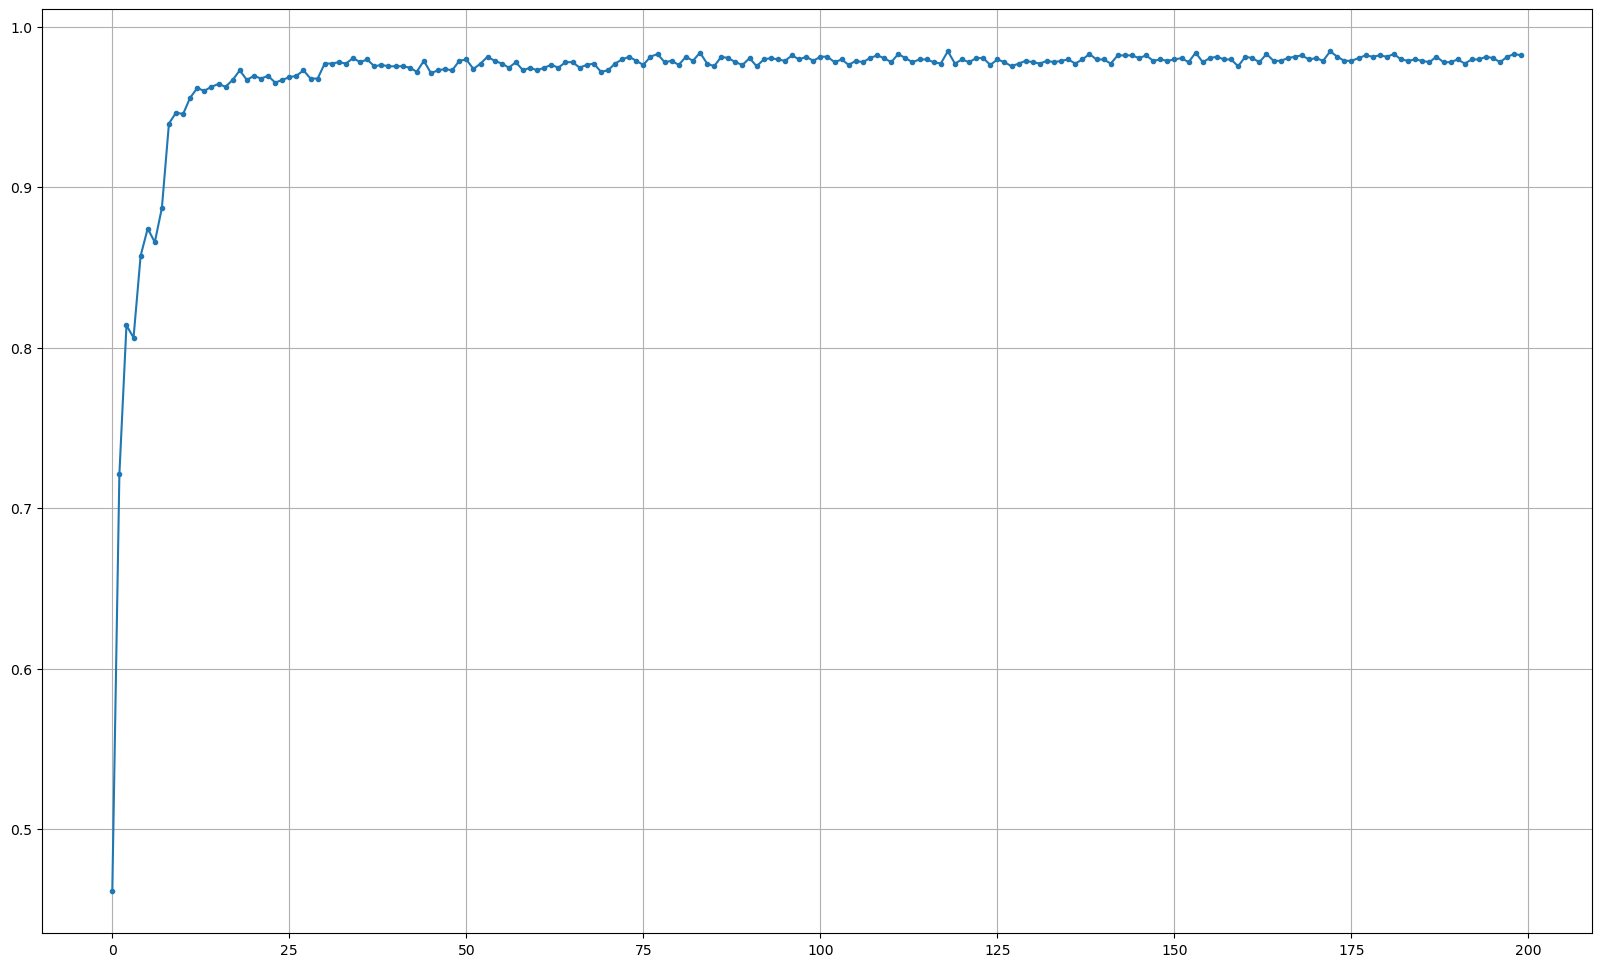

In [ ]:
plt.figure(figsize = (20,12))
plt.plot(range(200), acc, marker = '.')
plt.grid()
plt.show()

* 적절한 지점의 성능에 맞춰 변수 선택 : ==> 30~50개 정도면 충분!

In [ ]:
feature50 = r.loc[:49, 'feature_name']
x_train50 = x_train[feature50]
x_val50 = x_val[feature50]

In [ ]:
m1_2 = RandomForestClassifier()
m1_2.fit(x_train50, y_train)
p1_2 = m1_2.predict(x_val50)

In [ ]:
print('accuracy :',accuracy_score(y_val, p1_2))
print('='*60)
print(confusion_matrix(y_val, p1_2))
print('='*60)
print(classification_report(y_val, p1_2))

accuracy : 0.9779099405267629
[[230   0   0   0   0   0]
 [  0 203   6   0   0   0]
 [  0   7 211   0   0   0]
 [  0   0   0 175   2   3]
 [  0   0   0   4 158   3]
 [  0   0   0   0   1 174]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.97      0.97      0.97       209
          STANDING       0.97      0.97      0.97       218
           WALKING       0.98      0.97      0.97       180
WALKING_DOWNSTAIRS       0.98      0.96      0.97       165
  WALKING_UPSTAIRS       0.97      0.99      0.98       175

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



### (2) Logistic Regressin

#### 1) 전체 변수

In [ ]:
m2_1 = LogisticRegression()

m2_1.fit(x_train, y_train)
p2_1 = m2_1.predict(x_val)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('accuracy :',accuracy_score(y_val, p2_1))
print('='*60)
print(confusion_matrix(y_val, p2_1))
print('='*60)
print(classification_report(y_val, p2_1))

accuracy : 0.9881053525913339
[[230   0   0   0   0   0]
 [  0 203   6   0   0   0]
 [  0   6 212   0   0   0]
 [  0   0   0 180   0   0]
 [  0   0   0   0 165   0]
 [  0   0   0   2   0 173]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.97      0.97      0.97       209
          STANDING       0.97      0.97      0.97       218
           WALKING       0.99      1.00      0.99       180
WALKING_DOWNSTAIRS       1.00      1.00      1.00       165
  WALKING_UPSTAIRS       1.00      0.99      0.99       175

          accuracy                           0.99      1177
         macro avg       0.99      0.99      0.99      1177
      weighted avg       0.99      0.99      0.99      1177



#### 2) (옵션)적절히 선택한 변수
* 변수 중요도 상위 100로 모델링 해보기

In [ ]:
feature100 = r.loc[:99, 'feature_name']

In [ ]:
x_train100 = x_train[feature100]
x_val100 = x_val[feature100]

In [ ]:
m2_2 = LogisticRegression()

m2_2.fit(x_train100, y_train)
p2_2 = m2_2.predict(x_val100)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('accuracy :',accuracy_score(y_val, p2_2))
print('='*60)
print(confusion_matrix(y_val, p2_2))
print('='*60)
print(classification_report(y_val, p2_2))

accuracy : 0.9592183517417162
[[230   0   0   0   0   0]
 [  0 187  22   0   0   0]
 [  0  19 199   0   0   0]
 [  0   0   0 177   1   2]
 [  0   0   0   1 163   1]
 [  0   0   0   2   0 173]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.91      0.89      0.90       209
          STANDING       0.90      0.91      0.91       218
           WALKING       0.98      0.98      0.98       180
WALKING_DOWNSTAIRS       0.99      0.99      0.99       165
  WALKING_UPSTAIRS       0.98      0.99      0.99       175

          accuracy                           0.96      1177
         macro avg       0.96      0.96      0.96      1177
      weighted avg       0.96      0.96      0.96      1177



### (3) SVM

#### 1) kernel = 'rbf'

In [ ]:
#매개변수 C, gamma, kernel 모두 기본값
m3_1 = SVC(C=1, gamma=0.01, kernel = 'rbf', random_state=2022)
m3_1.fit(x_train, y_train)
p3_1 = m3_1.predict(x_val)

In [ ]:
print('accuracy :',accuracy_score(y_val, p3_1))
print('='*60)
print(confusion_matrix(y_val, p3_1))
print('='*60)
print(classification_report(y_val, p3_1))

accuracy : 0.9762107051826678
[[230   0   0   0   0   0]
 [  0 196  13   0   0   0]
 [  0  13 205   0   0   0]
 [  0   0   0 180   0   0]
 [  0   0   0   0 165   0]
 [  0   0   0   2   0 173]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.94      0.94      0.94       209
          STANDING       0.94      0.94      0.94       218
           WALKING       0.99      1.00      0.99       180
WALKING_DOWNSTAIRS       1.00      1.00      1.00       165
  WALKING_UPSTAIRS       1.00      0.99      0.99       175

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



#### 2) kernel = 'linear'

In [ ]:
m3_2 = SVC(C=1, gamma=0.01, kernel = 'linear', random_state=2022)
m3_2.fit(x_train, y_train)
p3_2 = m3_2.predict(x_val)

In [ ]:
print('accuracy :',accuracy_score(y_val, p3_2))
print('='*60)
print(confusion_matrix(y_val, p3_2))
print('='*60)
print(classification_report(y_val, p3_2))

accuracy : 0.9864061172472387
[[230   0   0   0   0   0]
 [  0 200   9   0   0   0]
 [  0   7 211   0   0   0]
 [  0   0   0 180   0   0]
 [  0   0   0   0 165   0]
 [  0   0   0   0   0 175]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.97      0.96      0.96       209
          STANDING       0.96      0.97      0.96       218
           WALKING       1.00      1.00      1.00       180
WALKING_DOWNSTAIRS       1.00      1.00      1.00       165
  WALKING_UPSTAIRS       1.00      1.00      1.00       175

          accuracy                           0.99      1177
         macro avg       0.99      0.99      0.99      1177
      weighted avg       0.99      0.99      0.99      1177



#### 3) 하이퍼파라미터 튜닝

* test 전체 수행하기(12 ~ 15분 소요)

In [ ]:
# 딕셔너리 형태로 관심있는 매개변수의 그리드 설정하기
param_grid = {'C': [0.01, 1, 100],
             'gamma': [0.0001, 0.001, 0.1, 1],
              'kernel': ['linear', 'rbf'] }

# 생성
# refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재학습시킴.
model_svc = SVC()
m3_3= GridSearchCV (model_svc, param_grid, return_train_score=True) #cross-validation 옵션 추가? cv=5

# 학습
# train data로 param_grid의 하이퍼 파라미터들을 순차적으로 학습/평가 .
m3_3.fit(x_train, y_train)

# 결과
# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(m3_3.cv_results_)

In [ ]:
print('최적파라미터:', m3_3.best_params_)
print('='*60)
print('최고성능:', m3_3.best_score_)
print('='*60)

최적파라미터: {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
최고성능: 0.98448187758609


* 예측 및 평가

In [ ]:
p3_3 = m3_3.predict(x_val)

In [ ]:
print('accuracy :',accuracy_score(y_val, p3_3))
print('='*60)
print(confusion_matrix(y_val, p3_3))
print('='*60)
print(classification_report(y_val, p3_3))

accuracy : 0.9864061172472387
[[230   0   0   0   0   0]
 [  0 200   9   0   0   0]
 [  0   7 211   0   0   0]
 [  0   0   0 180   0   0]
 [  0   0   0   0 165   0]
 [  0   0   0   0   0 175]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.97      0.96      0.96       209
          STANDING       0.96      0.97      0.96       218
           WALKING       1.00      1.00      1.00       180
WALKING_DOWNSTAIRS       1.00      1.00      1.00       165
  WALKING_UPSTAIRS       1.00      1.00      1.00       175

          accuracy                           0.99      1177
         macro avg       0.99      0.99      0.99      1177
      weighted avg       0.99      0.99      0.99      1177



### (4) Deep Learning

#### 1) 딥러닝을 위한 전처리

In [ ]:
#인코딩 (레이블인코딩)
data['Activity_num'] = data['Activity'].map({'LAYING':0, 'SITTING':1, 'STANDING':2, 'WALKING':3, 'WALKING_DOWNSTAIRS':4, 'WALKING_UPSTAIRS':5 } )

In [ ]:
x = data.drop(['Activity', 'Activity_num'], axis = 1)
y2 = data.loc[:, 'Activity_num']

x_train, x_val, y_train2, y_val2 = train_test_split(x, y2, test_size = .3, random_state = 2023)

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

#### 2) 모델1

In [ ]:
# 메모리 정리
clear_session()

# 모델링
nfeatures=561
m4_1 = Sequential(
   [ Dense(512, input_shape = (nfeatures,), activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(6, activation = 'softmax') ]
    )

# 요약
m4_1.summary()

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,614 (1.76 MB)

 Trainable params: 460,614 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y_train

1313               WALKING
5747               SITTING
5262               SITTING
1949    WALKING_DOWNSTAIRS
1780               SITTING
               ...        
884                SITTING
5852      WALKING_UPSTAIRS
2743               SITTING
5657                LAYING
4951              STANDING
Name: Activity, Length: 4704, dtype: object

In [ ]:
#예측 및 평가
m4_1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history = m4_1.fit(x_train, y_train2, epochs = 50, validation_split=0.2).history

Epoch 1/50


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9360 - val_loss: 0.3279
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2722 - val_loss: 0.2137
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2266 - val_loss: 0.1998
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1499 - val_loss: 0.2075
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1198 - val_loss: 0.1058
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1102 - val_loss: 0.1174
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1175 - val_loss: 0.0851
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0825 - val_loss: 0.1435
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0762 - val_loss: 0.0611
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0749 - val_loss: 0.0852
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0893 - val_loss: 0.1563
Epoch 12/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

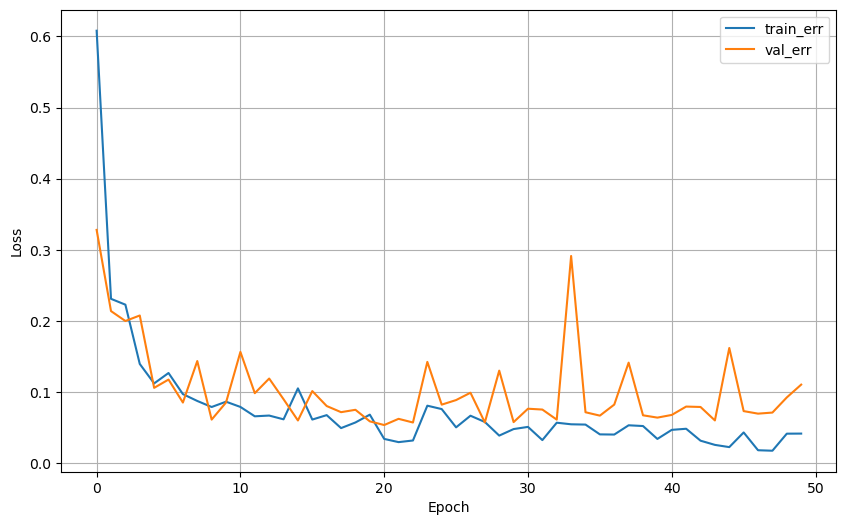

In [ ]:
# 학습결과 확인
dl_history_plot(history)

In [ ]:
# 예측
p4_1 = m4_1.predict(x_val)
p4_1[:5]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[1.7340129e-08, 1.3479622e-08, 1.7532840e-06, 9.9995112e-01,
        3.9884807e-07, 4.6657966e-05],
       [1.7925316e-09, 7.6190991e-05, 9.9992371e-01, 2.8870351e-08,
        4.1125001e-09, 3.8941671e-08],
       [9.9999678e-01, 3.1699760e-06, 3.0975403e-11, 4.0401779e-11,
        8.0692092e-11, 8.9474446e-09],
       [4.0190902e-05, 9.7704929e-01, 2.2872036e-02, 2.2764502e-06,
        8.8901406e-06, 2.7306945e-05],
       [9.9999976e-01, 2.6201437e-07, 1.1453996e-11, 9.7118555e-12,
        1.6446036e-11, 2.6315727e-09]], dtype=float32)

In [ ]:
p4_1 = np.argmax(p4_1, axis = 1)

In [ ]:
# 평가
print(accuracy_score(y_val2, p4_1))
print(confusion_matrix(y_val2, p4_1))
print(classification_report(y_val2, p4_1))


0.9620396600566572
[[351   3   0   0   0   0]
 [  0 272  56   0   0   0]
 [  0   6 320   0   0   0]
 [  0   0   1 270   0   0]
 [  0   0   0   0 232   0]
 [  0   0   0   1   0 253]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       354
           1       0.97      0.83      0.89       328
           2       0.85      0.98      0.91       326
           3       1.00      1.00      1.00       271
           4       1.00      1.00      1.00       232
           5       1.00      1.00      1.00       254

    accuracy                           0.96      1765
   macro avg       0.97      0.97      0.97      1765
weighted avg       0.97      0.96      0.96      1765



#### 3) 모델2

In [ ]:
# 메모리 정리
clear_session()

# 모델링
nfeatures=561
m4_2 = Sequential(
   [ Dense(512, input_shape = (nfeatures,), activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(6, activation = 'softmax') ]
    )

# 요약
m4_2.summary()

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,406 (2.01 MB)

 Trainable params: 526,406 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#예측 및 평가
m4_2.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')

history = m4_2.fit(x_train, y_train2, epochs = 100, validation_split=0.2).history

Epoch 1/100


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4144 - val_loss: 0.6672
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5526 - val_loss: 0.3494
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3218 - val_loss: 0.2401
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2235 - val_loss: 0.2040
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1964 - val_loss: 0.1895
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1628 - val_loss: 0.1394
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1271 - val_loss: 0.1213
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1062 - val_loss: 0.1262
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0934 - val_loss: 0.1194
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1147 - val_loss: 0.0930
Epoch 11/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0716 - val_loss: 0.0825
Epoch 12/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

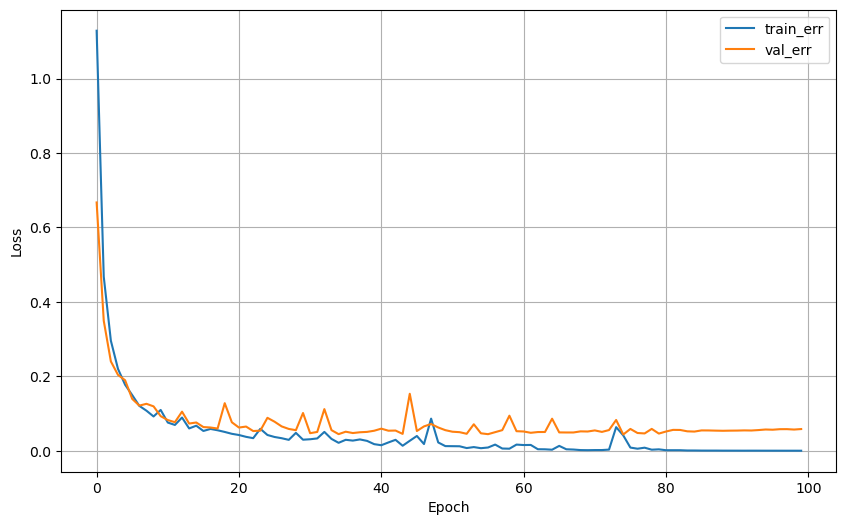

In [ ]:
# 학습결과 확인
dl_history_plot(history)

In [ ]:
# 예측
p4_2 = m4_2.predict(x_val)
p4_2[:5]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[3.8641073e-09, 1.6993353e-10, 1.0820077e-08, 9.9999917e-01,
        7.5916464e-09, 8.5168398e-07],
       [1.0787434e-09, 4.1887904e-07, 9.9999774e-01, 1.6923323e-07,
        9.0196335e-07, 7.4693065e-07],
       [1.0000000e+00, 3.6499981e-09, 1.3183282e-13, 7.4358153e-10,
        3.7325750e-12, 3.0737107e-10],
       [1.4519769e-07, 9.9999905e-01, 4.5286330e-07, 6.7637529e-08,
        3.0238532e-08, 2.4003521e-07],
       [1.0000000e+00, 1.7022109e-10, 2.0155652e-14, 1.3240428e-10,
        3.3847545e-13, 4.7189228e-11]], dtype=float32)

In [ ]:
p4_2 = np.argmax(p4_2, axis = 1)

In [ ]:
# 평가
print(accuracy_score(y_val2, p4_2))
print(confusion_matrix(y_val2, p4_2))
print(classification_report(y_val2, p4_2))


0.9830028328611898
[[354   0   0   0   0   0]
 [  0 313  15   0   0   0]
 [  0  13 313   0   0   0]
 [  0   0   0 271   0   0]
 [  0   0   0   0 231   1]
 [  0   0   0   1   0 253]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       354
           1       0.96      0.95      0.96       328
           2       0.95      0.96      0.96       326
           3       1.00      1.00      1.00       271
           4       1.00      1.00      1.00       232
           5       1.00      1.00      1.00       254

    accuracy                           0.98      1765
   macro avg       0.98      0.98      0.98      1765
weighted avg       0.98      0.98      0.98      1765



## 4.성능비교

* 세부 요구사항
    - 각 모델에 대해서 test 데이터로 성능 측정후, 데이터프레임으로 저장하고 비교한다.

In [ ]:
#전체 데이터 불러오기
file2 = "data01_test.csv"
newdata = pd.read_csv(path+file2)

# subject 삭제
newdata.drop('subject', axis=1, inplace=True)

# 딥러닝을 위한 전처리
newdata['Activity_num'] = newdata['Activity'].map({'LAYING':0, 'SITTING':1, 'STANDING':2, 'WALKING':3, 'WALKING_DOWNSTAIRS':4, 'WALKING_UPSTAIRS':5 } )

# x, y 분할
x = newdata.drop(['Activity_num','Activity'], axis = 1)
y = newdata.Activity
y2 = data.Activity_num

In [ ]:
model_no = ['m1_1','m1_2', 'm2_1', 'm2_2', 'm3_1', 'm3_2', 'm3_3', 'm4_1', 'm4_2']
algorithm = ['rf','rf', 'LR', 'LR', 'svm', 'svm', 'svm', 'dl', 'dl']
pred = [p1_1, p1_2, p2_1, p2_2, p3_1, p3_2, p3_3, p4_1, p4_2]

result = pd.DataFrame({'model_no':[], 'algorithm':[],'accuracy':[],'f1_0':[],'f1_1':[],'f1_2':[],'f1_3':[],'f1_4':[],'f1_5':[]})

for i in range(9) :
    if i < 7 :
        f1 = list(f1_score(y_val, pred[i], average = None))
        acc = accuracy_score(y_val, pred[i])
    else :
        acc = accuracy_score(y_val2, pred[i])
        f1 = list(f1_score(y_val2, pred[i], average = None))

    row = [model_no[i], algorithm[i], acc]
    result.loc[i] = row + f1

result

,model_no,algorithm,accuracy,f1_0,f1_1,f1_2,f1_3,f1_4,f1_5
0,m1_1,rf,0.975361,1.000000,0.951220,0.954955,0.983146,0.976048,0.988571
1,m1_2,rf,0.977910,1.000000,0.968974,0.970115,0.974930,0.969325,0.980282
2,m2_1,LR,0.988105,1.000000,0.971292,0.972477,0.994475,1.000000,0.994253
3,m2_2,LR,0.959218,1.000000,0.901205,0.906606,0.983333,0.990881,0.985755
4,m3_1,svm,0.976211,1.000000,0.937799,0.940367,0.994475,1.000000,0.994253
5,m3_2,svm,0.986406,1.000000,0.961538,0.963470,1.000000,1.000000,1.000000
6,m3_3,svm,0.986406,1.000000,0.961538,0.963470,1.000000,1.000000,1.000000
7,m4_1,dl,0.962040,0.995745,0.893268,0.910384,0.996310,1.000000,0.998028
8,m4_2,dl,0.983003,1.000000,0.957187,0.957187,0.998158,0.997840,0.996063
